# Market Intelligence with Principal Components Analysis and Gaussian Mixed Model Clustering

In this notebook, we will analyze a dataset containing annual spending amounts on a range of consumables of a given market for internal structure, to understand the variation in the different types of market agents.  We apply Principal Components Analysis to understand underlying variation in the customers, and use a Gaussian Mixed Model to segment the market.  Actionable items based on market intelligence are discussed.

In [1]:
# Import libraries: NumPy, pandas, matplotlib, metrics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.metrics import silhouette_score

# Import clustering modules
from sklearn.cluster import KMeans
from sklearn.mixture import GMM

# Tell iPython to include plots inline in the notebook
%matplotlib inline

-------
## Data


In [2]:
# Read dataset
data = pd.read_csv("agent_purchasing.csv")
print "Dataset has {} rows, {} columns".format(*data.shape)
print data.head()  # print the first 5 rows

Dataset has 440 rows, 6 columns
   Fresh  Milk  Grocery  Frozen  Detergents_Paper  Delicatessen
0  12669  9656     7561     214              2674          1338
1   7057  9810     9568    1762              3293          1776
2   6353  8808     7684    2405              3516          7844
3  13265  1196     4221    6404               507          1788
4  22615  5410     7198    3915              1777          5185


-------
## Market Agent Feature Transformation

We will be using PCA and ICA to start to understand the structure of the data.

### PCA

As PCA will attempt to find orthogonal linear combinations of the features that have the highest variance, we might expect the PCs to pick up an 'overall products' purchasing as positive spending of any product is likely correlated with positive purchasing of any other product.

In [3]:
# TODO: Apply PCA with the same number of dimensions as variables in the dataset
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(data)

# Print the components and the amount of variance in the data contained in each dimension
print "PCA components are:\n", pca.components_
print "Ranked explained variance of PCA components:\n", pca.explained_variance_ratio_

PCA components are:
[[-0.97653685 -0.12118407 -0.06154039 -0.15236462  0.00705417 -0.06810471]
 [-0.11061386  0.51580216  0.76460638 -0.01872345  0.36535076  0.05707921]
 [-0.17855726  0.50988675 -0.27578088  0.71420037 -0.20440987  0.28321747]
 [-0.04187648 -0.64564047  0.37546049  0.64629232  0.14938013 -0.02039579]
 [ 0.015986    0.20323566 -0.1602915   0.22018612  0.20793016 -0.91707659]
 [-0.01576316  0.03349187  0.41093894 -0.01328898 -0.87128428 -0.26541687]]
Ranked explained variance of PCA components:
[ 0.45961362  0.40517227  0.07003008  0.04402344  0.01502212  0.00613848]


__Analysis__

We note that the first two Principal Components explain over 85% of the variance in the dataset (at 45.9% and 40.5%, respectively).

The first PC has a very strong correlation with the 'fresh products' attribute and a relatively negligible correlation with the other attributes.  This suggests that the purchasing of 'fresh products' explains a significant amount of variation in the dataset as a whole.  The second PC has correlation with 'milk products', 'grocery products', and 'detergents and paper products'.  The second PC is not as straight-forward in interpretation as the primary, but we might surmise that these three attributes--when compared to 'fresh products', 'frozen products', and 'deli products'--constitute "standard offerings of a market" and thus this PC captures some measure of the client's "type" of store.

PCA analysis seems to provide the most insight, as the "explained variance" metric of the PCA algorithm output informs us of the relative importance of the linear combinations that are derived.  This is in contrast to the ICA method below, in which relative "importance" is not output by the algorithm.  

### ICA

For ICA, we might expect our latent factors to capture some sort of notion of 'facility size' or 'gross sales', both of which would capture positive correlation between any or all of the attributes.  ICA will find statistically independent linear combinations of our features.

In [11]:
# TODO: Fit an ICA model to the data
# Note: Adjust the data to have center at the origin first!
from sklearn.decomposition import FastICA
data_centered = data - data.mean() # centering
ica = FastICA()

ica.fit(data_centered)

# Print the independent components
print "ICA:\n", ica.components_ * 100000

ICA:
[[-0.02201859  1.53347986 -0.68835612  0.03717793  0.05039452  0.03696283]
 [ 0.03427122 -0.10967278 -1.02956362  0.23840658  3.03904861  0.06917453]
 [ 0.03941283 -0.16047659  1.20952475  0.12488278 -0.84689089 -0.68334422]
 [-0.03832025 -0.13486753  0.11591858  1.75140048  0.04170913 -0.20303782]
 [ 0.53140824  0.15587574 -0.15659849 -0.21519445  0.37432424 -0.50989792]
 [-0.01728303 -0.50278432  0.04144543 -0.07898288  0.26391962  4.38542239]]


__Analysis__

Due to the random seeding during the ICA's initialization, we arbitrarily number the 6 ICA latent vectors and point out that their magnitude and signage will vary.  Thus:

- One vector has positive correlation between 'fresh product' (~0.4 magnitude after adjustment) and 'Detergents/paper product' (~0.2) and negligible correlation with the other products (<=0.1).  We might surmise that this vector is picking up a 'fresh produce' type of establishment, such as a food stand.

- A second vector has strong association with the 'Delicatessen product' (~1.8) and negligible association with the other products (<=0.06).  We might surmise that this vector is picking up a 'deli/sandwhich/short-order' type of establishment.

- Similar to reasonging from PCA analysis above, the ICA components recoverd from the FastICA algorithm could potentially be used as basis for a hypothetical clustering based upon the 'type' of customer.

--------
## Market Segmentation

In this section we discuss our choice of a Gaussian Mixed Models clustering, which implements expectation-maximization, over the popular K-Means clustering.

### Potential Cluster Types

- **K Means:** The primary advantage of the K Means versus GMM clustering is its straight-forward interpretation.  The algorithm itself is simple (heuristically linear), computationally very fast in practice, and has guaranteed convergence (though the clusters themselves are not guaranteed to be optimal).  For these reasons it is a widely-appropriate clustering method.  The biggest drawback to K Means, however, is its "hard clustering" approach that prevents irregular, dissimilar, or overlapping clusters from being accurately identified.  When any of the above are assumed present in the data, it would be more appropriate to utilize a probabilistic "soft clustering" model that incorporates non-zero factor covariances such as GMM, below.

- **GMM:** As stated above, the GMM has the added benefit beyond K Means in that it incorporates non-zero factor covariances in a probabilistic manner, leading to better behavior in modeling oblong, dissimilarly shaped clusters.  It loosens the assumption of identical covariance matrixes, allowing the employed expectation maximization algorithm to attempt to optimize unknown distribution parameters.  The expectation maximization algorithm also has an endemic probabilistic component for the fitting of observations to assumed distributions, allowing for observations to "belong" to several different clusters.  This is useful in the unsupervised setting when the data's ultimate categorization is unknown.  The drawback to the GMM model is its algortihms' computational complexities relative to that of K Means.  Though the expectation maximization algorithm is proven to not diverge, it is suseptible to becoming stuck in local optima due to its "hill-climbing" nature.  

It is also important to point out that the performance of both GMM and KMeans depend heavily on their initialization- that is, the choice of cluster means prior to algorithm iteration.

In [5]:
# Remove outlying observations from our data set in order to better-visualize clusters.
data = data[(np.abs(stats.zscore(data)) < 3).all(axis=1)]

# Reduce the data to two dimensions using PCA.
reduced_fit = PCA(n_components=2).fit(data)
reduced_data = reduced_fit.transform(data)

### Visualizing GMM Cluster Behavior

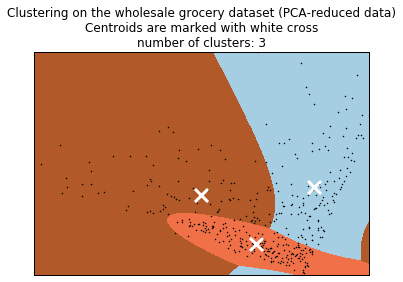

Clustering has a Silhouette Score of 0.344417635359


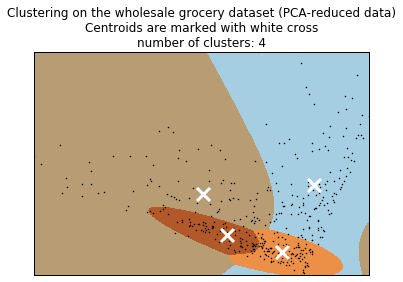

Clustering has a Silhouette Score of 0.28853511446


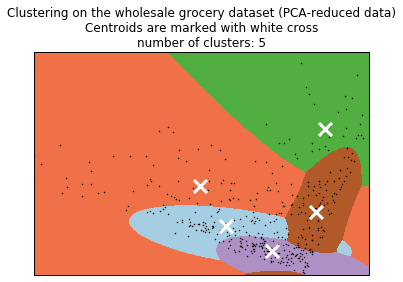

Clustering has a Silhouette Score of 0.267295722496


In [6]:
# Plot the decision boundary by building a mesh grid to populate a graph.
x_min, x_max = reduced_data[:, 0].min() - 1, reduced_data[:, 0].max() + 1
y_min, y_max = reduced_data[:, 1].min() - 1, reduced_data[:, 1].max() + 1
hx = (x_max-x_min)/1000.
hy = (y_max-y_min)/1000.
xx, yy = np.meshgrid(np.arange(x_min, x_max, hx), np.arange(y_min, y_max, hy))

# Range of clusters
cluster_range = [3,4,5]

# Plotting Routine
for cluster_num in cluster_range:
    GMM_clf = GMM(n_components=cluster_num,covariance_type="full").fit(reduced_data)
    GMM_pred = GMM_clf.predict(np.c_[xx.ravel(), yy.ravel()])
    GMM_centroids = GMM_clf.means_
    reshaped_pred = GMM_pred.reshape(xx.shape)
   
    plt.figure(cluster_num)
    plt.clf()
    plt.imshow(reshaped_pred, interpolation='nearest',
               extent=(xx.min(), xx.max(), yy.min(), yy.max()),
               cmap=plt.cm.Paired,
               aspect='auto', origin='lower')

    plt.plot(reduced_data[:, 0], reduced_data[:, 1], 'k.', markersize=2)
    plt.scatter(GMM_centroids[:, 0], GMM_centroids[:, 1],
                marker='x', s=169, linewidths=3,
                color='w', zorder=10)
    plt.title('Clustering on the wholesale grocery dataset (PCA-reduced data)\n'
              'Centroids are marked with white cross\n'
              'number of clusters: {}'.format(cluster_num))
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xticks(())
    plt.yticks(())
    plt.show()

    labels = GMM_clf.predict(reduced_data)
    ss = silhouette_score(reduced_data, labels, metric='euclidean')
    print "Clustering has a Silhouette Score of {}".format(ss)


### Analysis:

We need to transform the coordinates of the Gaussian Mix means back into the full dimensionality of the source data, which we do below.

In [7]:
# Recover average customers in terms of original features
cluster_num = 4
average_customer = reduced_fit.inverse_transform(GMM(n_components=cluster_num,covariance_type="full").fit(reduced_data).means_)

print "Average customer purchasing of",cluster_num,"clusters:","\n\n", data.columns.values, "\n", average_customer

Average customer purchasing of 4 clusters: 

['Fresh' 'Milk' 'Grocery' 'Frozen' 'Detergents_Paper' 'Delicatessen'] 
[[  4894.4997658    2072.11260406   2380.61049087   2455.50964055
     616.75941619    828.57938253]
 [ 20753.17029954   5031.22888205   6810.29676801   3248.59878747
    2043.67525383   1493.99802677]
 [  4456.12164466   8644.10093934  13158.76565377   1670.80318751
    5363.71055609   1451.64527022]
 [ 14419.69926277   2087.13025447   2154.08790075   3133.89335139
     206.08699627   1058.35339219]]


__Discussion__

We choose to visualize three clusterings (three, four and five clusters) and their respective 'silhouette scores'.  We state without loss of generality that we observe more "overlapping" of the individual clusters as more clusters are fit to the data, as the trending of the silhouette score to zero indicates.  Similarly, the addition of more clusters to the model brings the intercluster distances closer, making segmentation less clear-cut.  With this in mind, we take the "less is more" approach and focus on cluster models of 4 clusters or less.

Turning our attention to the PCA-reduced dataset, we will combine the information contained in the PCA analysis with the heuristic visual inspection of the clustering behavior to settle on a Gaussian Mixed Model with a full covariance matrix and four clusters.  From PCA, we know that the two orthogonal linear combinations of the original data with the highest variance point strongly towards the 'fresh product' variable, and separately to a combination of 'milk', 'grocery', and 'detergents/paper' products.  Using this knowledge in conjunction with a visualization of the clusterings, we make two delineations of customers: 1. those with a high or low level of fresh product purchasing, and 2. those with a high or low level of overall purchasing.  These two divisions give us four clusters overall: 

1. high fresh product and high overall purchasing
2. low fresh product and high overall purchasing
3. low fresh product and low overall purchasing
4. low fresh product and low overall purchasing.  

Theoretical examples of purchasers that fall in the above segments might be:

1. __cluster 1 (high fresh product and high overall purchasing)__: 'regional supermaket', such as a Vons.  
2.  __cluster 2 (low fresh product and high overall purchasing)__: "box stores" that also carries foodstuffs, such as a Walmart.  
3.  __cluster 3 (high fresh product and low overall purchasing)__: neighborhood food markets
4. __cluster 4 (low fresh product and low overall purchasing)__: local non-food retailer such as a pharmacy, a deli, or a corner bodega.   

----------
## Actionable Items based on Market Intel

Based on the above analysis, we suggest the following based on intelligence:

- **A/B testing:** We instruct the pursuit of A/B testing within these clusters to determine what effect a new delivery schedule would have on the segment as a whole.  A/B testing stipulates that some percentage of the homogenous group (we'll say 50%) be held out for testing a new feature while the remainder acts as the control.  In the grocer's case, a random 50% of the segment will incur the new delivery, while the remaining 50% incurs the old delivery.  The experiment is run for some number of weeks and the results are compared.

- **Model Validation:** We generalize purchasing behavior to "types" of customers.  To validate this analysis, we suggest obtaining labels for these customers in terms of the "type" of store (and therefore turning this unsupervised problem into a supervised one).  If our PCA analysis is correct, we would expect obtained labels to match clusters stratified on 'fresh product' purchasing and 'overal product' purchasing.

- **Model Robusticity:** Another experiement we might want to run is to tease out the effects of other unobserved variables such as facility square footage and average shelf turnover.  We can do this by either obtaining this information from customers directly or using other available proxy data.  We would then approach the analysis again using PCA, and make hypothesis about the Principle Components as necessary.